## Skincancer classification using balanced dataset of size 250 samples each

### Part 3 - Training a medium sized CNN (Convolutional Neural Network)

#### Experiment 2: 

Training & testing a medium CNN model with balanced data set of 250 samples each with an input size 256 x 256 x 3 and a batch size of 16

Reading input data from "skinlesion_250_split" dataset

In [6]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from glob import glob #to walk through folder structure
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import load_model

from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding

from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix,f1_score

import warnings
warnings.filterwarnings("ignore")
np.random.seed(42)

#2 -> Filter out INFO & WARNING messages 
# tf.autograph.set_verbosity(1)

In [2]:
batch_size = 32
img_height = 128
img_width = 128

train_dir = 'data/skinlesion_250_split/train'
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  labels='inferred',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_dir = 'data/skinlesion_250_split/val'
val_ds = tf.keras.utils.image_dataset_from_directory(
  val_dir,
  labels='inferred',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_dir = 'data/skinlesion_250_split/test'
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  labels='inferred',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names
print(class_names)

Found 1225 files belonging to 7 classes.
Metal device set to: Apple M2
INFO:tensorflow:Converted call: <function paths_and_labels_to_dataset.<locals>.<lambda> at 0x107ce7d30>
    args: (<tf.Tensor 'args_0:0' shape=() dtype=string>,)
    kwargs: {}

Found 350 files belonging to 7 classes.
INFO:tensorflow:Converted call: <function paths_and_labels_to_dataset.<locals>.<lambda> at 0x107ce7550>
    args: (<tf.Tensor 'args_0:0' shape=() dtype=string>,)
    kwargs: {}

Found 175 files belonging to 7 classes.
INFO:tensorflow:Converted call: <function paths_and_labels_to_dataset.<locals>.<lambda> at 0x15f2fde50>
    args: (<tf.Tensor 'args_0:0' shape=() dtype=string>,)
    kwargs: {}

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


2022-12-10 22:10:45.764105: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-10 22:10:45.764441: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


2022-12-10 21:23:29.534880: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


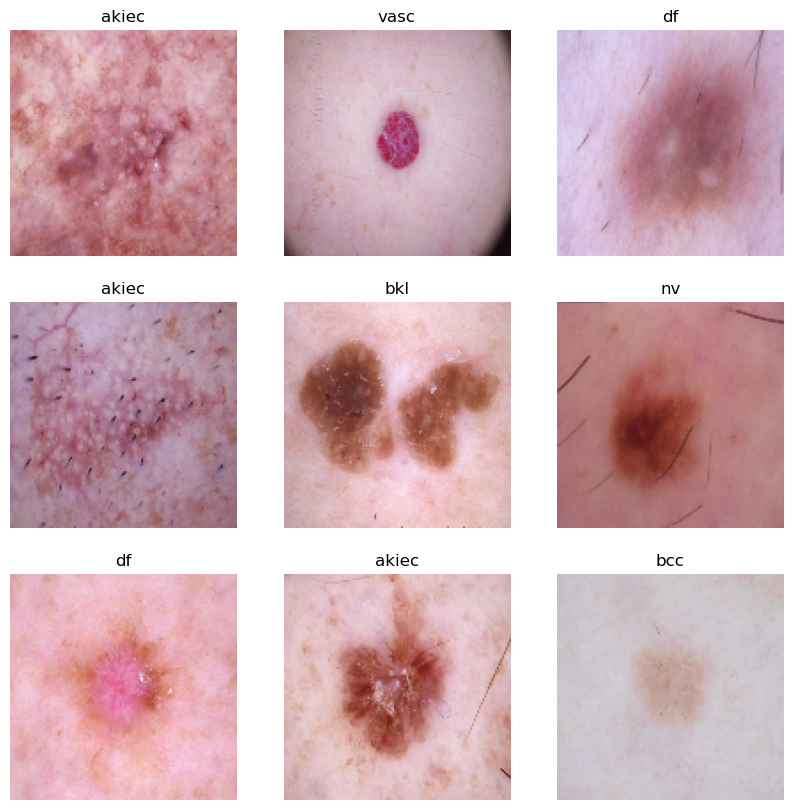

In [3]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(3):
      for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [6]:
##configuring dataset for performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(100).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [3]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1), #tested with 0.3 -too much fluctuation in val performance
    layers.RandomZoom(0.1),
  ]
)

INFO:tensorflow:Converted call: <bound method BaseImageAugmentationLayer._augment of <keras.layers.preprocessing.image_preprocessing.RandomFlip object at 0x107d1b3a0>>
    args: ({'images': <tf.Tensor 'random_flip/map/while/TensorArrayV2Read/TensorListGetItem:0' shape=(128, 128, 3) dtype=float32>},)
    kwargs: {}

INFO:tensorflow:Converted call: <function vectorized_map.<locals>.loop_fn at 0x107ce75e0>
    args: (<tf.Tensor 'random_rotation/loop_body/PlaceholderWithDefault:0' shape=() dtype=int32>,)
    kwargs: {}

INFO:tensorflow:Converted call: <function vectorized_map.<locals>.loop_fn at 0x107ce7f70>
    args: (<tf.Tensor 'random_zoom/loop_body/PlaceholderWithDefault:0' shape=() dtype=int32>,)
    kwargs: {}



In [7]:
#model build
num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(32, activation='relu'),
  layers.Dropout(0.1),
  layers.Dense(num_classes)
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 256)     7168      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 256)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       295040    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 128)      0         
 2D)                                                  

In [8]:
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1,patience=10,min_delta=0.001)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
epochs=50
history=model.fit(train_ds, validation_data=val_ds, epochs=epochs,callbacks=[es])

Epoch 1/50


2022-12-10 21:27:06.809036: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


39/39 [==============================] - ETA: 0s - loss: 2.0217 - accuracy: 0.1714

2022-12-10 21:27:27.949388: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


39/39 [==============================] - 23s 533ms/step - loss: 2.0217 - accuracy: 0.1714 - val_loss: 8.7540 - val_accuracy: 0.1429
Epoch 2/50
39/39 [==============================] - 20s 515ms/step - loss: 1.8943 - accuracy: 0.2122 - val_loss: 1.9460 - val_accuracy: 0.1429
Epoch 3/50
39/39 [==============================] - 20s 514ms/step - loss: 1.8721 - accuracy: 0.2392 - val_loss: 1.9301 - val_accuracy: 0.1914
Epoch 4/50
39/39 [==============================] - 20s 519ms/step - loss: 1.8322 - accuracy: 0.2735 - val_loss: 1.9362 - val_accuracy: 0.2057
Epoch 5/50
39/39 [==============================] - 20s 513ms/step - loss: 1.7914 - accuracy: 0.2890 - val_loss: 1.9195 - val_accuracy: 0.1543
Epoch 6/50
39/39 [==============================] - 20s 513ms/step - loss: 1.7482 - accuracy: 0.3086 - val_loss: 3.4654 - val_accuracy: 0.1429
Epoch 7/50
39/39 [==============================] - 20s 509ms/step - loss: 1.7335 - accuracy: 0.3102 - val_loss: 3.1565 - val_accuracy: 0.1886
Epoch 8/50

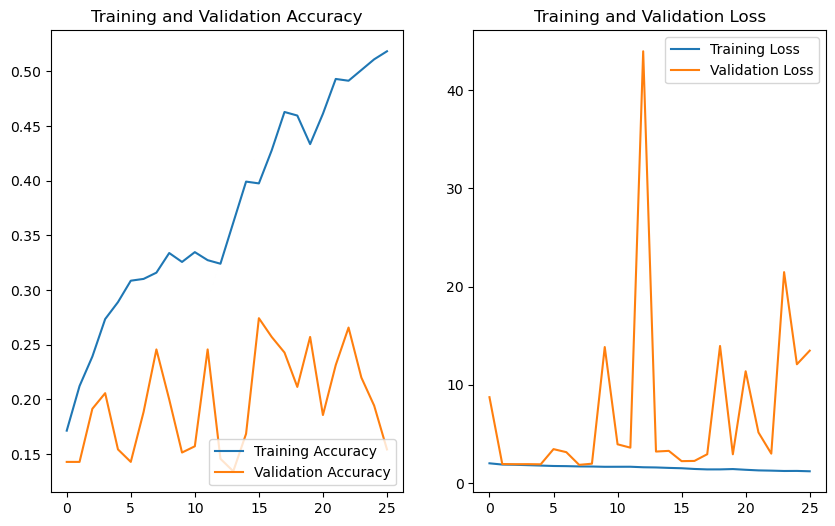

In [9]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(26)

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Increasing network size

In [10]:
#model build
num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(64, activation='relu'),
  layers.Dense(32, activation='relu'),
  layers.Dropout(0.1),
  layers.Dense(num_classes,activation='softmax')
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                  

In [11]:
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1,patience=10,min_delta=0.001)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
epochs=50
history=model.fit(train_ds, validation_data=val_ds, epochs=epochs,callbacks=[es])

Epoch 1/50


2022-12-10 21:47:13.814331: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


39/39 [==============================] - ETA: 0s - loss: 2.1796 - accuracy: 0.2359

2022-12-10 21:47:25.839211: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


39/39 [==============================] - 13s 291ms/step - loss: 2.1796 - accuracy: 0.2359 - val_loss: 1.9879 - val_accuracy: 0.1429
Epoch 2/50
39/39 [==============================] - 11s 282ms/step - loss: 1.6784 - accuracy: 0.3216 - val_loss: 1.9033 - val_accuracy: 0.2629
Epoch 3/50
39/39 [==============================] - 11s 284ms/step - loss: 1.5720 - accuracy: 0.3780 - val_loss: 1.8651 - val_accuracy: 0.2257
Epoch 4/50
39/39 [==============================] - 11s 283ms/step - loss: 1.4125 - accuracy: 0.4498 - val_loss: 1.8577 - val_accuracy: 0.1914
Epoch 5/50
39/39 [==============================] - 11s 283ms/step - loss: 1.3286 - accuracy: 0.4914 - val_loss: 1.7840 - val_accuracy: 0.3000
Epoch 6/50
39/39 [==============================] - 11s 285ms/step - loss: 1.3234 - accuracy: 0.4808 - val_loss: 1.8651 - val_accuracy: 0.2343
Epoch 7/50
39/39 [==============================] - 11s 284ms/step - loss: 1.2213 - accuracy: 0.5159 - val_loss: 1.6163 - val_accuracy: 0.2629
Epoch 8/50

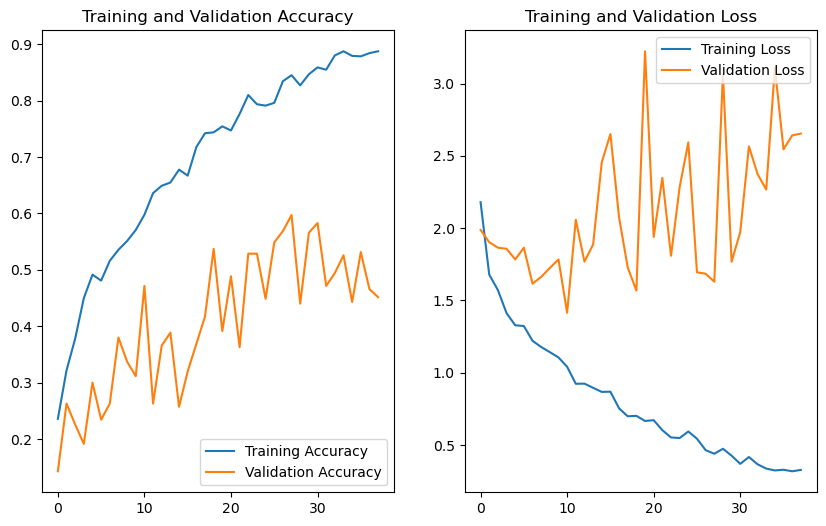

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(38)

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Comments:

As validation loss is increasing,

    - more drop out
    
    - more data 
    
    - reduce model complexity

In [4]:
#model build - another dropout between dense layers
num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(64, activation='relu'),
  layers.Dropout(0.25),
  layers.Dense(32, activation='relu'),
  layers.Dropout(0.1),
  layers.Dense(num_classes,activation='softmax')
])
model.summary()

INFO:tensorflow:Converted call: <bound method BaseImageAugmentationLayer._augment of <keras.layers.preprocessing.image_preprocessing.RandomFlip object at 0x107d1b3a0>>
    args: ({'images': <tf.Tensor 'sequential/random_flip/map/while/TensorArrayV2Read/TensorListGetItem:0' shape=(128, 128, 3) dtype=float32>},)
    kwargs: {}

INFO:tensorflow:Converted call: <function vectorized_map.<locals>.loop_fn at 0x15f2fdee0>
    args: (<tf.Tensor 'sequential/random_rotation/loop_body/PlaceholderWithDefault:0' shape=() dtype=int32>,)
    kwargs: {}

INFO:tensorflow:Converted call: <function vectorized_map.<locals>.loop_fn at 0x15f2fdee0>
    args: (<tf.Tensor 'sequential/random_zoom/loop_body/PlaceholderWithDefault:0' shape=() dtype=int32>,)
    kwargs: {}

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 128, 128, 3)       0         
                        

In [5]:
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1,patience=10,min_delta=0.001)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
epochs=50
history=model.fit(train_ds, validation_data=val_ds, epochs=epochs,callbacks=[es])

Epoch 1/50
INFO:tensorflow:Converted call: <function Model.make_train_function.<locals>.train_function at 0x168c61af0>
    args: (<tensorflow.python.data.ops.iterator_ops.OwnedIterator object at 0x168cf19d0>,)
    kwargs: {}

INFO:tensorflow:<function Model.make_train_function.<locals>.train_function at 0x168c61af0> is not cached for subkey ConversionOptions[{}]
INFO:tensorflow:Converted call: <function Model.make_train_function.<locals>.step_function at 0x15f78db80>
    args: (<keras.engine.sequential.Sequential object at 0x16882edf0>, <tensorflow.python.data.ops.iterator_ops.OwnedIterator object at 0x168cf19d0>)
    kwargs: None

INFO:tensorflow:Converted call: <function Model.make_train_function.<locals>.step_function.<locals>.run_step at 0x15f7c34c0>
    args: ((<tf.Tensor 'IteratorGetNext:0' shape=(None, 128, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(None,) dtype=int32>),)
    kwargs: {}

INFO:tensorflow:Converted call: <bound method BaseImageAugmentationLayer.

INFO:tensorflow:Converted call: <function OptimizerV2._distributed_apply.<locals>.apply_grad_to_update_var at 0x1777bcf70>
    args: (<tf.Variable 'conv2d_2/bias:0' shape=(128,) dtype=float32>, <tf.Tensor 'Adam/IdentityN:5' shape=(128,) dtype=float32>)
    kwargs: {}

INFO:tensorflow:Converted call: <function StrategyExtendedV2._replica_ctx_update.<locals>.merge_fn at 0x1777bce50>
    args: (<tensorflow.python.distribute.distribute_lib._DefaultDistributionStrategy object at 0x107d01ee0>, <tf.Tensor 'Adam/IdentityN:6' shape=(128,) dtype=float32>)
    kwargs: {}

INFO:tensorflow:Converted call: <function OptimizerV2._distributed_apply.<locals>.apply_grad_to_update_var at 0x1777bcf70>
    args: (<tf.Variable 'batch_normalization/gamma:0' shape=(128,) dtype=float32>, <tf.Tensor 'Adam/IdentityN:6' shape=(128,) dtype=float32>)
    kwargs: {}

INFO:tensorflow:Converted call: <function StrategyExtendedV2._replica_ctx_update.<locals>.merge_fn at 0x1777bce50>
    args: (<tensorflow.python.distri

INFO:tensorflow:Converted call: <bound method LossFunctionWrapper.call of <keras.losses.SparseCategoricalCrossentropy object at 0x168cbaca0>>
    args: (<tf.Tensor 'ExpandDims:0' shape=(None, 1) dtype=int32>, <tf.Tensor 'sequential_1/dense_2/Softmax:0' shape=(None, 7) dtype=float32>)
    kwargs: {}

INFO:tensorflow:Converted call: <bound method Reduce.update_state of <keras.metrics.base_metric.Mean object at 0x168cba7f0>>
    args: (<tf.Tensor 'sparse_categorical_crossentropy/weighted_loss/value:0' shape=() dtype=float32>,)
    kwargs: {'sample_weight': <tf.Tensor 'strided_slice:0' shape=() dtype=int32>}

INFO:tensorflow:Converted call: <function ReplicaContextBase.all_reduce.<locals>.batch_all_reduce at 0x284b6b670>
    args: (<tensorflow.python.distribute.distribute_lib._DefaultDistributionStrategy object at 0x107d01ee0>, <tf.Tensor 'gradient_tape/sequential_1/conv2d/Conv2D/Conv2DBackpropFilter:0' shape=(3, 3, 3, 32) dtype=float32>, <tf.Tensor 'gradient_tape/sequential_1/conv2d/BiasA

INFO:tensorflow:Converted call: <function OptimizerV2._distributed_apply.<locals>.apply_grad_to_update_var at 0x284b6b670>
    args: (<tf.Variable 'dense_1/kernel:0' shape=(64, 32) dtype=float32>, <tf.Tensor 'Adam/IdentityN:10' shape=(64, 32) dtype=float32>)
    kwargs: {}

INFO:tensorflow:Converted call: <function StrategyExtendedV2._replica_ctx_update.<locals>.merge_fn at 0x284b62ee0>
    args: (<tensorflow.python.distribute.distribute_lib._DefaultDistributionStrategy object at 0x107d01ee0>, <tf.Tensor 'Adam/IdentityN:11' shape=(32,) dtype=float32>)
    kwargs: {}

INFO:tensorflow:Converted call: <function OptimizerV2._distributed_apply.<locals>.apply_grad_to_update_var at 0x284b6b670>
    args: (<tf.Variable 'dense_1/bias:0' shape=(32,) dtype=float32>, <tf.Tensor 'Adam/IdentityN:11' shape=(32,) dtype=float32>)
    kwargs: {}

INFO:tensorflow:Converted call: <function StrategyExtendedV2._replica_ctx_update.<locals>.merge_fn at 0x284b62ee0>
    args: (<tensorflow.python.distribute.dis

2022-12-10 22:11:43.247994: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-10 22:11:43.250067: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


39/39 [==============================] - ETA: 0s - loss: 2.0601 - accuracy: 0.2473INFO:tensorflow:Converted call: <function Model.make_test_function.<locals>.test_function at 0x284b62ee0>
    args: (<tensorflow.python.data.ops.iterator_ops.OwnedIterator object at 0x284d4d670>,)
    kwargs: {}

INFO:tensorflow:<function Model.make_test_function.<locals>.test_function at 0x284b62ee0> is not cached for subkey ConversionOptions[{}]
INFO:tensorflow:Converted call: <function Model.make_test_function.<locals>.step_function at 0x168f0e0d0>
    args: (<keras.engine.sequential.Sequential object at 0x16882edf0>, <tensorflow.python.data.ops.iterator_ops.OwnedIterator object at 0x284d4d670>)
    kwargs: None

INFO:tensorflow:Converted call: <function Model.make_test_function.<locals>.step_function.<locals>.run_step at 0x168c25430>
    args: ((<tf.Tensor 'IteratorGetNext:0' shape=(None, 128, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(None,) dtype=int32>),)
    kwargs: {}

INFO:ten

2022-12-10 22:11:55.619981: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


39/39 [==============================] - 14s 314ms/step - loss: 2.0601 - accuracy: 0.2473 - val_loss: 1.9338 - val_accuracy: 0.2057
Epoch 2/50
39/39 [==============================] - 12s 310ms/step - loss: 1.7846 - accuracy: 0.2955 - val_loss: 1.9335 - val_accuracy: 0.1371
Epoch 3/50
39/39 [==============================] - 12s 309ms/step - loss: 1.6545 - accuracy: 0.3339 - val_loss: 1.8955 - val_accuracy: 0.2086
Epoch 4/50
39/39 [==============================] - 12s 313ms/step - loss: 1.6481 - accuracy: 0.3502 - val_loss: 1.9262 - val_accuracy: 0.1400
Epoch 5/50
39/39 [==============================] - 12s 313ms/step - loss: 1.5706 - accuracy: 0.3845 - val_loss: 1.8573 - val_accuracy: 0.2657
Epoch 6/50
39/39 [==============================] - 12s 310ms/step - loss: 1.5204 - accuracy: 0.3902 - val_loss: 1.9111 - val_accuracy: 0.1543
Epoch 7/50
39/39 [==============================] - 12s 310ms/step - loss: 1.4565 - accuracy: 0.4196 - val_loss: 1.7861 - val_accuracy: 0.3286
Epoch 8/50

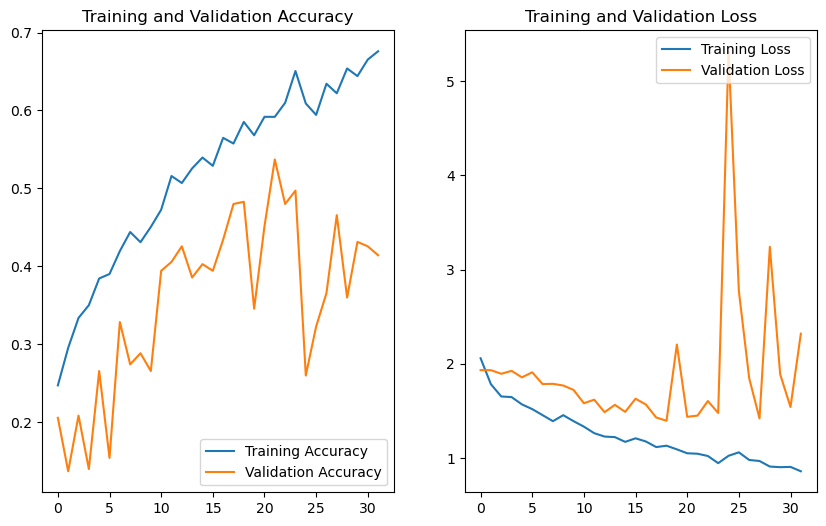

In [7]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(32)

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [8]:
extend_epochs =25
total_epochs = history.epoch[-1] +extend_epochs

history=model.fit(train_ds, validation_data=val_ds, 
                  initial_epoch=history.epoch[-1],
                  epochs=total_epochs,callbacks=[es])

Epoch 32/56
39/39 [==============================] - 12s 312ms/step - loss: 0.8455 - accuracy: 0.6694 - val_loss: 1.8032 - val_accuracy: 0.4657
Epoch 33/56
39/39 [==============================] - 12s 311ms/step - loss: 0.9076 - accuracy: 0.6457 - val_loss: 1.6015 - val_accuracy: 0.5029
Epoch 34/56
39/39 [==============================] - 12s 312ms/step - loss: 0.8570 - accuracy: 0.6727 - val_loss: 2.0836 - val_accuracy: 0.4257
Epoch 35/56
39/39 [==============================] - 12s 313ms/step - loss: 0.8323 - accuracy: 0.6767 - val_loss: 1.4956 - val_accuracy: 0.5286
Epoch 36/56
39/39 [==============================] - 12s 311ms/step - loss: 0.8052 - accuracy: 0.7004 - val_loss: 1.4633 - val_accuracy: 0.5143
Epoch 37/56
39/39 [==============================] - 12s 312ms/step - loss: 0.7920 - accuracy: 0.7118 - val_loss: 1.6902 - val_accuracy: 0.4914
Epoch 38/56
39/39 [==============================] - 12s 311ms/step - loss: 0.7365 - accuracy: 0.7322 - val_loss: 2.1752 - val_accuracy:

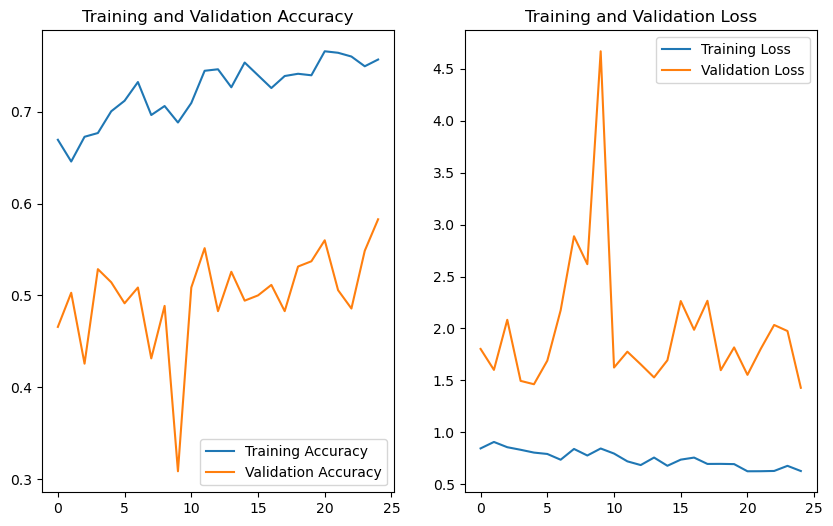

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(25)

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
extend_epochs =25
total_epochs = history.epoch[-1] +extend_epochs

history=model.fit(train_ds, validation_data=val_ds, 
                  initial_epoch=history.epoch[-1],
                  epochs=total_epochs,callbacks=[es])

Epoch 56/80
39/39 [==============================] - 13s 314ms/step - loss: 0.5901 - accuracy: 0.7837 - val_loss: 1.7286 - val_accuracy: 0.5314
Epoch 57/80
39/39 [==============================] - 13s 319ms/step - loss: 0.6023 - accuracy: 0.7722 - val_loss: 1.6922 - val_accuracy: 0.5486
Epoch 58/80
39/39 [==============================] - 13s 322ms/step - loss: 0.6127 - accuracy: 0.7706 - val_loss: 1.7777 - val_accuracy: 0.5229
Epoch 59/80
39/39 [==============================] - 13s 319ms/step - loss: 0.7396 - accuracy: 0.7551 - val_loss: 2.0491 - val_accuracy: 0.5400
Epoch 60/80
39/39 [==============================] - 13s 315ms/step - loss: 0.6020 - accuracy: 0.7706 - val_loss: 2.5711 - val_accuracy: 0.4429
Epoch 61/80
39/39 [==============================] - 13s 316ms/step - loss: 0.5903 - accuracy: 0.7812 - val_loss: 1.6917 - val_accuracy: 0.5371
Epoch 62/80
39/39 [==============================] - 13s 315ms/step - loss: 0.5501 - accuracy: 0.7943 - val_loss: 1.8063 - val_accuracy:

### Comments:

Accuracy is not improving very much. Too much training time. 